Seeing that Hyperface with VGG16 as main model is so big, we decide to try to train in a 'smaller' architecture (SqueezeNet https://arxiv.org/abs/1602.07360v3).

In [1]:
from keras import backend as K
from keras.models import Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
import time
import numpy as np
import h5py
import squeeze

Using TensorFlow backend.


Testing SqueezeNet

In [2]:
model = squeeze.SqueezeNet()

path = '/home/lmiguel/Projects/datasets/coco/images/test2017/000000000665.jpg'
img = image.load_img(path, target_size=(227, 227))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds))

Predicted: [[('n02123045', 'tabby', 0.80854654), ('n02123159', 'tiger_cat', 0.14428306), ('n02124075', 'Egyptian_cat', 0.043808553), ('n02971356', 'carton', 0.00093967305), ('n02127052', 'lynx', 0.0006034543)]]


Dropping classifier block

In [14]:
model = squeeze.SqueezeNet()
model = Model(inputs=model.input, outputs=model.get_layer('drop9').output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 113, 113, 64)  1792        input_3[0][0]                    
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0           relu_conv1[0][0]                 
___________________________________________________________________________________________

<!--<img src="squeezenet-architecture.png"/>-->
<img src="HyperFace-architecture.small.png"/>

In [6]:
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, GlobalAveragePooling2D, merge
from keras.layers.merge import concatenate

# fire2/concat (56x56x128) porque se asemeja a paper (51x51x96)
conv1a_input = model.get_layer('fire2/concat').output
# con kernel=9x9/9 llegamos a 6x6x128 en paper es 6x6x256
conv1a = Convolution2D(128, (9,9), strides=(9,9), activation='relu', padding='valid', name='conv1a')(conv1a_input)
print(conv1a_input.shape, '->', conv1a.shape)

# pool5 (13x13x256) paper (13x13x384)
conv3a_input = model.get_layer('pool5').output
conv3a = Convolution2D(128, (2,2), strides=(2,2), activation='relu', padding='valid', name='conv3a')(conv3a_input)
print(conv3a_input.shape, '->', conv3a.shape)

# no tiene nombre así que le nombramos conv5a
# drop9 (13x13x512) paper (13x13x256)
conv5a_input = model.get_layer('drop9').output
conv5a = Convolution2D(128, (2,2), strides=(2,2), activation='relu', padding='valid', name='conv5a')(conv5a_input)
print(conv5a_input.shape, '->', conv5a.shape)

# combinación: 6x6x384 (paper: 6x6x768)
concat = concatenate([conv1a, conv3a, conv5a], axis=-1, name='concat')
print(concat.shape)

# reducción de dimensión: 6x6x128 (paper: 6x6x192)
conv_all = Convolution2D(128, (1, 1), activation='relu', padding='valid', name='conv_all')(concat)
print(conv_all.shape)

# completamente conectadas
fc_full = Flatten(input_shape=conv_all.shape, name='fc_full')(conv_all)
print(fc_full.shape)

(?, 56, 56, 128) -> (?, 6, 6, 128)
(?, 13, 13, 256) -> (?, 6, 6, 128)
(?, 13, 13, 512) -> (?, 6, 6, 128)
(?, 6, 6, 384)
(?, 6, 6, 128)
(?, ?)


In [8]:
from keras.regularizers import l2

# face/non-face
fc_detecton = Dense(256, name='fc_detecton', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
face_nonface = Dense(2, name='face_nonface', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_detecton)
# print(fc_detecton.shape, face_nonface.shape)

fc_landmarks = Dense(256, name='fc_landmarks', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
landmarks = Dense(42, name='landmarks', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_landmarks)
# print(fc_landmarks.shape, landmarks.shape)

fc_visibility = Dense(256, name='fc_visibility', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
visibility = Dense(21, name='visibility', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_visibility)
# print(fc_visibility.shape, visibility.shape)

fc_pose = Dense(256, name='fc_pose', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
roll_pitch_yaw = Dense(3, name='roll_pitch_yaw', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_pose)
# print(fc_pose.shape, roll_pitch_yaw.shape)

fc_gender = Dense(256, name='fc_gender', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
male_female = Dense(2, name='male_female', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_gender)
# print(fc_gender.shape, male_female.shape)

hyperface = Model(inputs=model.input, outputs=[face_nonface, landmarks, visibility, roll_pitch_yaw, male_female])
hyperface.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 113, 113, 64)  1792        input_2[0][0]                    
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0           relu_conv1[0][0]                 
___________________________________________________________________________________________

In [9]:
import tensorflow as tf
import keras.backend as kb
import keras.losses as losses
from keras.optimizers import Adam, RMSprop

# loss from hyperface-with-squeezenet
def custom_mse_lm(y_true,y_pred):
    return kb.sign(kb.sum(kb.abs(y_true),axis=-1))*kb.sum(kb.square(tf.multiply((kb.sign(y_true)+1)*0.5, y_true-y_pred)),axis=-1)/kb.sum((kb.sign(y_true)+1)*0.5,axis=-1)

def custom_mse_pose(y_true,y_pred):
    return kb.sign(kb.sum(kb.abs(y_true),axis=-1))*losses.mean_squared_error(y_true,y_pred)

optimizer = Adam(lr=0.0001)
hyperface.compile(optimizer=optimizer,
                  loss={
                      'face_nonface': 'categorical_crossentropy',
                      'landmarks': custom_mse_lm,
                      'visibility': custom_mse_lm,
                      'roll_pitch_yaw': custom_mse_pose,
                      'male_female': 'categorical_crossentropy'},
                  loss_weights={
                      'face_nonface': 1,
                      'landmarks': 1,
                      'visibility': 1,
                      'roll_pitch_yaw': 1,
                      'male_female': 1})
print("hyperface model compiled")

hyperface model compiled


In [11]:
from keras.callbacks import ModelCheckpoint
import hf

print("Building Train Data Generator...")
train_data = hf.ImageDataGeneratorV2()

json_dir = '/home/lmiguel/Projects/deep-learning/hyperface'
train_data_flow = train_data.flow_from_directory(json_dir,
                                                 'positives.json', 
                                                 'negatives.json', 
                                                 output_type='hyperface', 
                                                 target_size=(227, 227),
                                                 pos_batch_size=128, 
                                                 neg_batch_size=128)

# # checkpoint
# filepath="weights-{epoch:02d}-{loss:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='train_loss', verbose=1, save_best_only=False, mode='min', period=30)
# callbacks_list = [checkpoint]

print("Start Training...")
# history = hyperface.fit_generator(train_data_flow, steps_per_epoch=100, epochs=300, callbacks=callbacks_list)
history = hyperface.fit_generator(train_data_flow, steps_per_epoch=100, epochs=10)

Building Train Data Generator...
Found 2 positive samples and 2 negative samples.
Start Training...
Epoch 1/10
100/100 [==============================] - 4s - loss: 23461.0084 - face_nonface_loss: 0.7070 - landmarks_loss: 23460.0163 - visibility_loss: 0.1236 - roll_pitch_yaw_loss: 0.1300 - male_female_loss: 0.0314     
Epoch 2/10
100/100 [==============================] - 4s - loss: 23463.2813 - face_nonface_loss: 0.6931 - landmarks_loss: 23462.3632 - visibility_loss: 0.1122 - roll_pitch_yaw_loss: 0.1126 - male_female_loss: 5.9605e-08     
Epoch 3/10
100/100 [==============================] - 4s - loss: 23459.2677 - face_nonface_loss: 0.6931 - landmarks_loss: 23458.3738 - visibility_loss: 0.1020 - roll_pitch_yaw_loss: 0.0984 - male_female_loss: 5.9605e-08     
Epoch 4/10
100/100 [==============================] - 4s - loss: 23453.5801 - face_nonface_loss: 0.6931 - landmarks_loss: 23452.7155 - visibility_loss: 0.0890 - roll_pitch_yaw_loss: 0.0822 - male_female_loss: 5.9605e-08     
Epoc

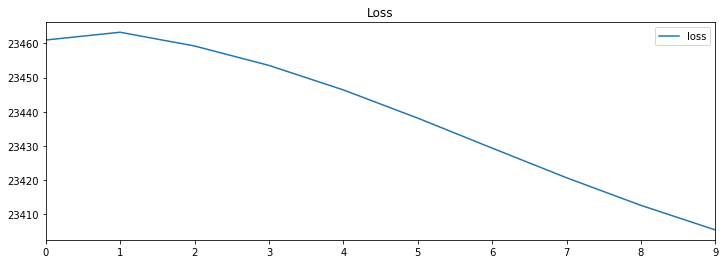

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.DataFrame(history.history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
# df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy')
df.plot(y=['loss'], figsize=(12,4), title='Loss')
# df

In [ ]:
import h5py
hyperface.save_weights("hyperface.weights.h5")

model_yaml = hyperface.to_yaml()
with open("hyperface.model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

# throws json non serializable exception
# model_json = hyperface.to_json()
# with open("hyperface.model.json", "w") as json_file:
#     json_file.write(model_json)

print("model written")